<img src="https://www.kaggle.com/static/images/site-logo.png" width=30% align='left'>

# Kaggle Competition: Titanic Dataset
<br>Link to the Competition: https://www.kaggle.com/c/titanic/overview

***
**Responsible:** Danillo Henrique F. Silva (https://github.com/dhsilva2912)
***

## Libraries:
***

In [75]:
#Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.externals import joblib

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
plt.style.use('ggplot')
%matplotlib inline

## Step 1: Load Dataset
***

In [2]:
#Extract Train Dataset:
df_titanic = pd.read_csv('data/train.csv')

df_titanic.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
403,404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.8500,NaN,S
175,176,0,3,"Klasen, Mr. Klas Albin",male,18.0,1,1,350404,7.8542,NaN,S


## Step 2: Understanding the Main Figures from the Dataset
***

In [3]:
#Inspect Columns and Values from Dataset:

print('Dataset Size : {}'.format(df_titanic.shape))
print('\nDataset Features: {}'.format(df_titanic.columns))
print('\nDataset Main Info:')
print(df_titanic.info())

Dataset Size : (891, 12)

Dataset Features: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Dataset Main Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None


### Step 2.1: Indetify the Main Features from the Model
***
**PassengerId:** The Unique Identifier for each Passenger onboard

**Survived:** Binary Classifier (0=No, 1=Yes), our <font color=red>**TARGET**</font>

**Pclass:** The Ticket Class (1=1st, 2=2nd, 3=3rd)

**Name:** The Passenger Name

**Sex:** The Passenger Sex (Male/Female)

**Age:** Age in Years.Age is fractional if less than 1. If estimated, is it in the form of xx.5

**SibSp:** # of parents / Children aboard the Titanic. The definition of family on this problem is: Sibling=brother,sister,stepbrother,stepsister / Spouse=husband,wife (mistresses and fiances were ignored)

**Parch:** # of parents / children aboard the Titanic. The definition of family relations are: Parent=mother,father / Child=daughter,son,stepdaughter,stepson.

**Ticket:** Ticket Number

**Fare:** Passenger fare

**Cabin:** Cabin number

**Embarked:** Port of Embarkation (C=Chebourg, Q=Queenstown, S=Southampton)

## Step 3: Exploratory Data Analysis + Feature Engineering
***

### Step 3.1: Survival
***

Class 0 (No): 61.62
Class 1 (Yes): 38.38


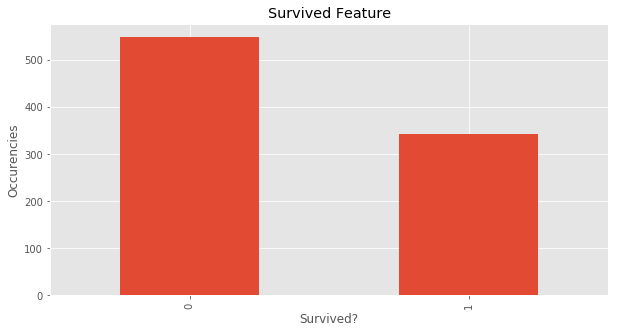

In [4]:
#Understand the Survival Rates:

df_titanic['Survived'].value_counts().plot(kind='bar',figsize=(10,5))

_= plt.title('Survived Feature')
_= plt.xlabel('Survived?')
_= plt.ylabel('Occurencies')

print('Class 0 (No): {}'.format(round(df_titanic['Survived'].value_counts()[0]/
                                      df_titanic['Survived'].value_counts().sum()*100,2)))
print('Class 1 (Yes): {}'.format(round(df_titanic['Survived'].value_counts()[1]/
                                       df_titanic['Survived'].value_counts().sum()*100,2)))

The Graph above indicates that we don't have a balanced base across the both Predictors Classes that we intend to predict.
This is a good hint that we'll take into account in order to **Stratify** our Train and Validate Samples.

### Step 3.2: Pclass
***

Class 1 (First): 24.24
Class 2 (Second): 20.65
Class 3 (Third): 55.11


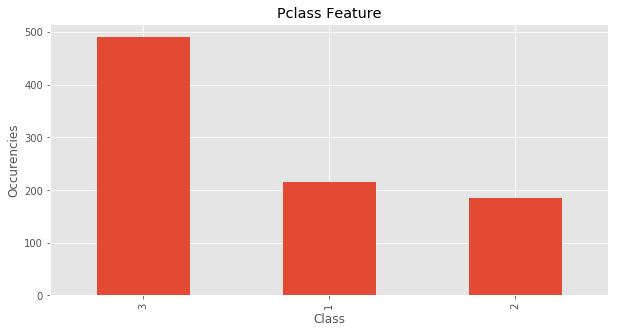

In [5]:
#Understand the Classes Relations:

df_titanic['Pclass'].value_counts().plot(kind='bar',figsize=(10,5))

_= plt.title('Pclass Feature')
_= plt.xlabel('Class')
_= plt.ylabel('Occurencies')

print('Class 1 (First): {}'.format(round(df_titanic['Pclass'].value_counts()[1]/
                                      df_titanic['Pclass'].value_counts().sum()*100,2)))
print('Class 2 (Second): {}'.format(round(df_titanic['Pclass'].value_counts()[2]/
                                       df_titanic['Pclass'].value_counts().sum()*100,2)))
print('Class 3 (Third): {}'.format(round(df_titanic['Pclass'].value_counts()[3]/
                                       df_titanic['Pclass'].value_counts().sum()*100,2)))

In order to properly use the **Pclass** Variable on our Dataset we need to Encode the Values, because the numbers represents the Classes that each Passenger have Travel. This means that this Variable is Categorical.

In [6]:
#Define Enconde Function - For All Categorical Features:

def Encode_Class(df, name):
    df = pd.concat([df, pd.get_dummies(df[name], prefix=name)], axis=1)
    df.drop(labels=name, axis=1, inplace=True)
    return df

In [7]:
#Apply Function on Dataset:

df_titanic = Encode_Class(df_titanic, 'Pclass')

df_titanic.sample(5)

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3
289,290,1,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,NaN,Q,0,0,1
705,706,0,"Morley, Mr. Henry Samuel (""Mr Henry Marshall"")",male,39.0,0,0,250655,26.0000,NaN,S,0,1,0
166,167,1,"Chibnall, Mrs. (Edith Martha Bowerman)",female,NaN,0,1,113505,55.0000,E33,S,1,0,0
809,810,1,"Chambers, Mrs. Norman Campbell (Bertha Griggs)",female,33.0,1,0,113806,53.1000,E8,S,1,0,0
42,43,0,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C,0,0,1


### Step 3.3: Name
***

In [8]:
#Inspect a few Name Examples:

df_titanic['Name'].sample(5)

634             Skoog, Miss. Mabel
379    Gustafsson, Mr. Karl Gideon
298          Saalfeld, Mr. Adolphe
135             Richard, Mr. Emile
252      Stead, Mr. William Thomas
Name: Name, dtype: object

It's possible to notice that all names follows a similar pattern:

```<Surname>, <Title>. <Name>```

In order to group this Feature we can inspect and understand how the people were grouped due their **Title**.

In [9]:
#Define Title Function:

def Get_Title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    return ""

In [10]:
#Apply Function and Inspect Results:

pd.crosstab(df_titanic['Name'].apply(Get_Title),df_titanic['Sex'])

Sex,female,male
Name,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


It's possible to notice that could be useful to Transform the **Title** into Categories, instead of using each Passenger Name.

But, we need to summarize the names in order to have a reasonable quantity of Variables. In order to do so, all categories that are minor than 10 Passengers are going to be grouped as **Other**.

In [11]:
#Define Name/Title transformation Function:

def Name_into_Titles(df, name):
    df['Title'] = df[name].apply(Get_Title)
    
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col',
                                       'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                       'Jonkheer', 'Dona'], 'Other')
        
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
      
    df.drop(labels=name, axis=1, inplace=True)
    
    df = Encode_Class(df, 'Title')
        
    return df

In [12]:
df_titanic = Name_into_Titles(df_titanic, 'Name')

df_titanic.sample(5)

,PassengerId,Survived,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
327,328,1,female,36.0,0,0,28551,13.0000,D,S,0,1,0,0,0,0,1,0
154,155,0,male,NaN,0,0,Fa 265302,7.3125,NaN,S,0,0,1,0,0,1,0,0
308,309,0,male,30.0,1,0,P/PP 3381,24.0000,NaN,C,0,1,0,0,0,1,0,0
400,401,1,male,39.0,0,0,STON/O 2. 3101289,7.9250,NaN,S,0,0,1,0,0,1,0,0
515,516,0,male,47.0,0,0,36967,34.0208,D46,S,1,0,0,0,0,1,0,0


### Step 3.4: Sex
***

Male: 64.76
Female: 35.24


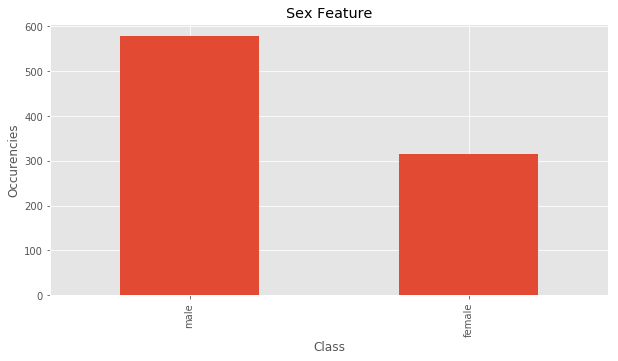

In [13]:
#Inspect Sex Feature:

df_titanic['Sex'].value_counts().plot(kind='bar',figsize=(10,5))

_= plt.title('Sex Feature')
_= plt.xlabel('Class')
_= plt.ylabel('Occurencies')

print('Male: {}'.format(round(df_titanic['Sex'].value_counts()['male']/
                                      df_titanic['Sex'].value_counts().sum()*100,2)))
print('Female: {}'.format(round(df_titanic['Sex'].value_counts()['female']/
                                       df_titanic['Sex'].value_counts().sum()*100,2)))

As we've seen before, we're going to transform This Feature into Categorical.

In [14]:
#Transform Sex Feature into Categorical:

df_titanic = Encode_Class(df_titanic,'Sex')

df_titanic.sample(5)

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male
744,745,1,31.0,0,0,STON/O 2. 3101288,7.925,NaN,S,0,0,1,0,0,1,0,0,0,1
327,328,1,36.0,0,0,28551,13.000,D,S,0,1,0,0,0,0,1,0,1,0
603,604,0,44.0,0,0,364511,8.050,NaN,S,0,0,1,0,0,1,0,0,0,1
377,378,0,27.0,0,2,113503,211.500,C82,C,1,0,0,0,0,1,0,0,0,1
579,580,1,32.0,0,0,STON/O 2. 3101286,7.925,NaN,S,0,0,1,0,0,1,0,0,0,1


### Step 3.5: Age
***

First, we need to create an strategy in order to deal with the missing data in the Feature.

We cannot exclude the all records, because this would affect the overall performance of the model.

The simplest approach is replace the NaN values by the median of the overall Feature.

In [15]:
#Replace NaN Values of the Age Feature:

df_titanic['Age'][np.isnan(df_titanic['Age'])] = df_titanic['Age'].median()

C:\Users\silvada010\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


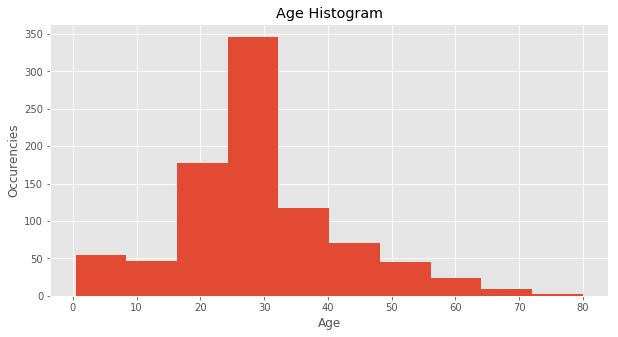

In [16]:
#Inspect Age Feature:

df_titanic['Age'].plot(kind='hist',figsize=(10,5))

_= plt.title('Age Histogram')
_= plt.xlabel('Age')
_= plt.ylabel('Occurencies')

We're going to transform this Feature into a Categorical, grouping the the ages as:

* Children: 0 up to 12
* Young: 13 up to 20
* Adult: 21 up to 40
* Elder: major than 41 

In [17]:
#Create Bins for Age Feature:

df_titanic['Age_Bin'] = pd.cut(df_titanic['Age'], bins=[0,12,20,40,120], labels=['Children','Young','Adult','Elder'])

df_titanic = Encode_Class(df_titanic,'Age_Bin')

df_titanic.sample(5)

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,...,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,Age_Bin_Children,Age_Bin_Young,Age_Bin_Adult,Age_Bin_Elder
424,425,0,18.0,1,1,370129,20.2125,NaN,S,0,...,0,1,0,0,0,1,0,1,0,0
886,887,0,27.0,0,0,211536,13.0000,NaN,S,0,...,0,0,0,1,0,1,0,0,1,0
325,326,1,36.0,0,0,PC 17760,135.6333,C32,C,1,...,1,0,0,0,1,0,0,0,1,0
27,28,0,19.0,3,2,19950,263.0000,C23 C25 C27,S,1,...,0,1,0,0,0,1,0,1,0,0
166,167,1,28.0,0,1,113505,55.0000,E33,S,1,...,0,0,1,0,1,0,0,0,1,0


### Step 3.6: SibSp / Parch
***

These two Features can be united in order to create a new Feature that will show us with how many family members each Passenger have traveled with.

Also, will indicate if the person have travelled alone.

In [18]:
#Create FamilySize Feature:

df_titanic['FamilySize'] = df_titanic['SibSp'] + df_titanic['Parch'] + 1

df_titanic['IsAlone'] = 0
df_titanic.loc[df_titanic['FamilySize']==1, 'IsAlone']=1

df_titanic.sample(5)

,PassengerId,Survived,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Pclass_1,...,Title_Mrs,Title_Other,Sex_female,Sex_male,Age_Bin_Children,Age_Bin_Young,Age_Bin_Adult,Age_Bin_Elder,FamilySize,IsAlone
334,335,1,28.00,1,0,PC 17611,133.6500,NaN,S,1,...,1,0,1,0,0,0,1,0,2,0
831,832,1,0.83,1,1,29106,18.7500,NaN,S,0,...,0,0,0,1,1,0,0,0,3,0
92,93,0,46.00,1,0,W.E.P. 5734,61.1750,E31,S,1,...,0,0,0,1,0,0,0,1,2,0
324,325,0,28.00,8,2,CA. 2343,69.5500,NaN,S,0,...,0,0,0,1,0,0,1,0,11,0
177,178,0,50.00,0,0,PC 17595,28.7125,C49,C,1,...,0,0,1,0,0,0,0,1,1,1


### Step 3.7: Ticket
***

As we already have the Class of each ticket of the Dataset, this Feature will not have much use in our Prediction. Due of that we're going to exclude this Feature from our Dataset.

In [19]:
#Exclude Ticket Feature:

df_titanic.drop(labels=['Ticket'], axis=1, inplace=True)

df_titanic.sample(5)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,Pclass_1,Pclass_2,...,Title_Mrs,Title_Other,Sex_female,Sex_male,Age_Bin_Children,Age_Bin_Young,Age_Bin_Adult,Age_Bin_Elder,FamilySize,IsAlone
126,127,0,28.0,0,0,7.7500,NaN,Q,0,0,...,0,0,0,1,0,0,1,0,1,1
410,411,0,28.0,0,0,7.8958,NaN,S,0,0,...,0,0,0,1,0,0,1,0,1,1
375,376,1,28.0,1,0,82.1708,NaN,C,1,0,...,1,0,1,0,0,0,1,0,2,0
132,133,0,47.0,1,0,14.5000,NaN,S,0,0,...,1,0,1,0,0,0,0,1,2,0
415,416,0,28.0,0,0,8.0500,NaN,S,0,0,...,1,0,1,0,0,0,1,0,1,1


### Step 3.8: Fare
***

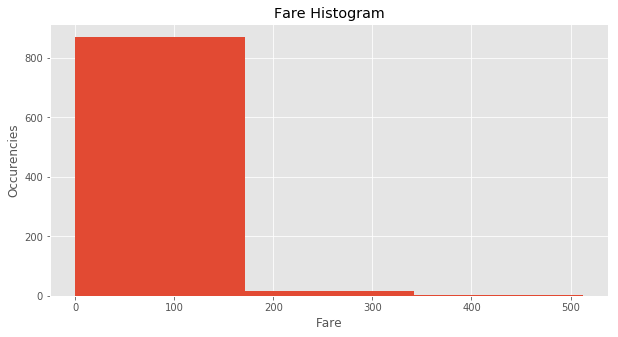

In [20]:
#Inspect Fare Feature:

df_titanic['Fare'].plot(kind='hist',bins=3, figsize=(10,5))

_= plt.title('Fare Histogram')
_= plt.xlabel('Fare')
_= plt.ylabel('Occurencies')

We're going to Transform this Variable also in Categorical, grouping the different bins together (same principle as used in the Age Feature). 

In [21]:
#Create Bins for Age Feature:

df_titanic['Fare_Bin'] = pd.cut(df_titanic['Fare'], bins=3, labels=['Low','Median','High'])

df_titanic = Encode_Class(df_titanic,'Fare_Bin')

df_titanic.sample(5)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,Pclass_1,Pclass_2,...,Sex_male,Age_Bin_Children,Age_Bin_Young,Age_Bin_Adult,Age_Bin_Elder,FamilySize,IsAlone,Fare_Bin_Low,Fare_Bin_Median,Fare_Bin_High
207,208,1,26.0,0,0,18.7875,NaN,C,0,0,...,1,0,0,1,0,1,1,1,0,0
38,39,0,18.0,2,0,18.0000,NaN,S,0,0,...,0,0,1,0,0,3,0,1,0,0
421,422,0,21.0,0,0,7.7333,NaN,Q,0,0,...,1,0,0,1,0,1,1,1,0,0
554,555,1,22.0,0,0,7.7750,NaN,S,0,0,...,0,0,0,1,0,1,1,1,0,0
290,291,1,26.0,0,0,78.8500,NaN,S,1,0,...,0,0,0,1,0,1,1,1,0,0


### Step 3.9: Cabin
***

In [22]:
#Inspect a few Cabin Examples:

df_titanic['Cabin'][df_titanic['Cabin'].isnull() == False].sample(5)

741     C46
669    C126
394      G6
712    C126
730      B5
Name: Cabin, dtype: object

In order to use this Feature, we need to understand the meaning of this data.

if we enter in the Titanic [wiki](https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/687px-Titanic_cutaway_diagram.png), it's possible to understand that the Cabin Strucure follows this pattern: ```<Deck> <Room>```

There are cases that we have more than one cabin for the same person, this means that the person have acquired Multiple cabins (which should reflect on the Fare Feature also).

But we have several Missing Data on this Feature also, which indicates that not all Passengers were identified on his respective Cabin.

In order to use this Feature, where going to Extract the Deck parameter from the Cabin and Normalize the Missing Data.

In [23]:
#Normalize the Missing Data from Cabin Feature:

df_titanic.fillna('N', inplace=True)

In [24]:
#Create Deck Feature:

df_titanic['Deck'] = df_titanic['Cabin'].str.slice(0,1)

df_titanic = Encode_Class(df_titanic,'Deck')

df_titanic.sample(5)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Embarked,Pclass_1,Pclass_2,...,Fare_Bin_High,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N,Deck_T
331,332,0,45.5,0,0,28.5000,C124,S,1,0,...,0,0,0,1,0,0,0,0,0,0
876,877,0,20.0,0,0,9.8458,N,S,0,0,...,0,0,0,0,0,0,0,0,1,0
369,370,1,24.0,0,0,69.3000,B35,C,1,0,...,0,0,1,0,0,0,0,0,0,0
341,342,1,24.0,3,2,263.0000,C23 C25 C27,S,1,0,...,0,0,0,1,0,0,0,0,0,0
857,858,1,51.0,0,0,26.5500,E17,S,1,0,...,0,0,0,0,0,1,0,0,0,0


### Step 3.10: Embarked
***

In [25]:
#Inspect Embarked Feature:

df_titanic['Embarked'].value_counts()

S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64

We're going to Transform the Missing Values on the Most Occured value from the Embarked Feature.

In [26]:
#Transform Missing Data from the Embarked Feature:

df_titanic['Embarked'].fillna('S', inplace=True)

df_titanic = Encode_Class(df_titanic,'Embarked')

df_titanic.sample(5)

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N,Deck_T,Embarked_C,Embarked_N,Embarked_Q,Embarked_S
783,784,0,28.0,1,2,23.450,N,0,0,1,...,0,0,0,0,1,0,0,0,0,1
664,665,1,20.0,1,0,7.925,N,0,0,1,...,0,0,0,0,1,0,0,0,0,1
436,437,0,21.0,2,2,34.375,N,0,0,1,...,0,0,0,0,1,0,0,0,0,1
212,213,0,22.0,0,0,7.250,N,0,0,1,...,0,0,0,0,1,0,0,0,0,1
152,153,0,55.5,0,0,8.050,N,0,0,1,...,0,0,0,0,1,0,0,0,0,1


## Step 4: Prepare the Train Dataset
***

### Step 4.1: Clean the Train w/ only the Transformed Features
***

In [27]:
#Inspect the Titanic Dataset:

print(df_titanic.columns)
df_titanic.sample(5)

Index(['PassengerId', 'Survived', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Other', 'Sex_female', 'Sex_male',
       'Age_Bin_Children', 'Age_Bin_Young', 'Age_Bin_Adult', 'Age_Bin_Elder',
       'FamilySize', 'IsAlone', 'Fare_Bin_Low', 'Fare_Bin_Median',
       'Fare_Bin_High', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E',
       'Deck_F', 'Deck_G', 'Deck_N', 'Deck_T', 'Embarked_C', 'Embarked_N',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N,Deck_T,Embarked_C,Embarked_N,Embarked_Q,Embarked_S
96,97,0,71.0,0,0,34.6542,A5,1,0,0,...,0,0,0,0,0,0,1,0,0,0
494,495,0,21.0,0,0,8.0500,N,0,0,1,...,0,0,0,0,1,0,0,0,0,1
26,27,0,28.0,0,0,7.2250,N,0,0,1,...,0,0,0,0,1,0,1,0,0,0
526,527,1,50.0,0,0,10.5000,N,0,1,0,...,0,0,0,0,1,0,0,0,0,1
455,456,1,29.0,0,0,7.8958,N,0,0,1,...,0,0,0,0,1,0,1,0,0,0


In [28]:
#Clear Titanic Dataset:

df_titanic = df_titanic[['Pclass_1','Pclass_2','Pclass_3',
                         'Title_Master','Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Other',
                         'Sex_female', 'Sex_male',
                         'Age_Bin_Children', 'Age_Bin_Young', 'Age_Bin_Adult', 'Age_Bin_Elder',
                         'FamilySize', 'IsAlone',
                         'Fare_Bin_Low', 'Fare_Bin_Median',
                         'Fare_Bin_High',
                         'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E','Deck_F', 'Deck_G', 'Deck_N', 'Deck_T',
                         'Embarked_C', 'Embarked_N','Embarked_Q', 'Embarked_S',
                         'Survived'
                        ]]

df_titanic.sample(5)

,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Sex_female,Sex_male,...,Deck_E,Deck_F,Deck_G,Deck_N,Deck_T,Embarked_C,Embarked_N,Embarked_Q,Embarked_S,Survived
263,1,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
528,0,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
771,0,0,1,0,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
780,0,0,1,0,1,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
596,0,1,0,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,1


### Step 4.2: Scale Continuous Features
***

In [38]:
#Scale FamilySize Feature:

df_titanic['FamilySize'] = StandardScaler().fit_transform(np.array(df_titanic['FamilySize']).reshape(-1,1))

C:\Users\silvada010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\silvada010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Step 4.3: Creat X and y Features
***

In [41]:
#Define X and y Features:

X = df_titanic.iloc[:,:-1]
y = df_titanic.iloc[:,-1]

### Step 4.4: Split Samples into Train and Validate
***

In [44]:
#Split Train and Test Samples:

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Step 5: Predictive Modelling
***

### Step 5.0: Prepare Results Function
***

In [66]:
#Prepare Variables to Store and Display Results:

model_matrix = {}

def Display_Model_Results(model_name, model, y_test, X_test):
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(20,10))
    fig.subplots_adjust(hspace =.2, wspace=.2)
       
    pred = model.predict(X_test)
    pred_proba_pos = model.predict_proba(X_test)[:,1]
    
    fpr, tpr, thresholds_forest = roc_curve(y_test.values,pred_proba_pos)

    print('{0} Model: {1}%'.format(model_name, round(roc_auc_score(y_test, pred_proba_pos)*100,2)))

    _= ax[0].plot(fpr, tpr, linewidth=2)
    _= ax[0].plot([0, 1], [0, 1], 'k--')

    _= ax[0].set_xlim(0,1)
    _= ax[0].set_ylim(0,1)

    _= ax[0].set_xlabel('False Positive Rate', fontsize=16)
    _= ax[0].set_ylabel('True Positive Rate', fontsize=16)
    _= ax[0].set_title('ROC Curve', fontsize=20)

    #Plot Confusion Matrix:

    sns.heatmap(confusion_matrix(y_test, pred),square=True, annot=True, linewidths=.5, cbar=False, robust=True,
                cmap='coolwarm', annot_kws={'size': 25}, fmt='g', ax=ax[1])

    _= ax[1].set_xticks([0.5,1.5])
    _= ax[1].set_yticks([0.5,1.5])

    _= ax[1].set_ylabel('True Results', fontsize=16)
    _= ax[1].set_xlabel('Predicted Results', fontsize=16)

    _= ax[1].set_title('Confusion Matrix', fontsize=20)
    
    model_matrix[model_name] = [round(roc_auc_score(y_test, pred_proba_pos)*100,2), model]

### Step 5.1: AdaBoost Model
***

In [49]:
#Initiate Model and Inspect Base Parameters:

AdaBoost_clf = AdaBoostClassifier()

AdaBoost_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': None}

In [48]:
#Create Grid Search Parameters based on Parameters:

random_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400],
               'learning_rate': [0.01, 0.05, 0.1,0.3,1,1.3, 1.5,1.7] ,
               'algorithm': ['SAMME', 'SAMME.R']}


In [59]:
#Set GridSearch Using RandomizedSearchCV:

kfold = KFold(n_splits=10, random_state=42)

model_random = RandomizedSearchCV(estimator=AdaBoost_clf,
                                  param_distributions=random_grid,
                                  n_iter=100,
                                  cv=kfold,
                                  verbose=1,
                                  random_state=42,
                                  scoring="accuracy",
                                  n_jobs=4)

In [60]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

model_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 305 tasks      | elapsed:   21.2s
[Parallel(n_jobs=4)]: Done 555 tasks      | elapsed:   41.8s
[Parallel(n_jobs=4)]: Done 905 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.3min finished


Executed in: 0 days 00:01:20.174988


In [64]:
#Choose the Best Model Calculated:

model_name = 'AdaBoost'

best_model = model_random.best_estimator_

AdaBoost Model: 87.56%


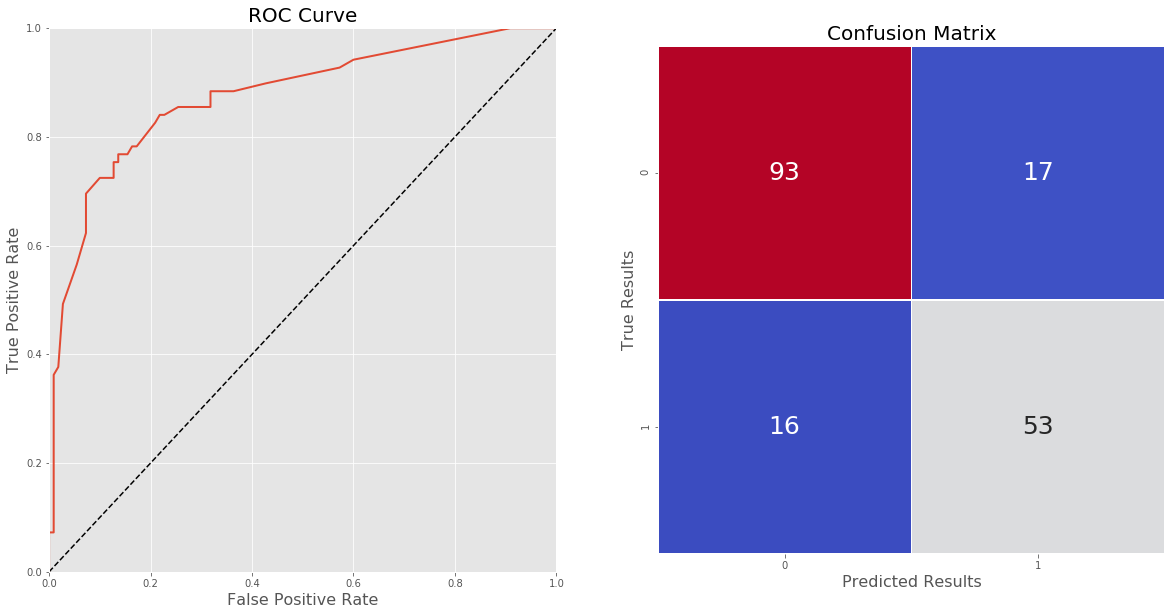

In [67]:
#Inspect Results:

Display_Model_Results(model_name, best_model, y_validate, X_validate)

### Step 5.2: Bagging Classifier
***

In [69]:
#Initiate Model and Inspect Base Parameters:

Bagging_clf = BaggingClassifier()

Bagging_clf.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [70]:
#Create Grid Search Parameters based on Parameters:

random_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
               'max_samples': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45],
               'max_features': [1, 2, 3, 4, 5, 6, 7]
               }


In [71]:
#Set GridSearch Using RandomizedSearchCV:

kfold = KFold(n_splits=10, random_state=42)

model_random = RandomizedSearchCV(estimator=Bagging_clf,
                                  param_distributions=random_grid,
                                  n_iter=100,
                                  cv=kfold,
                                  verbose=1,
                                  random_state=42,
                                  scoring="accuracy",
                                  n_jobs=4)

In [72]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

model_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  70 tasks      | elapsed:    3.4s


Executed in: 0 days 00:00:15.931107


[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   15.8s finished


In [73]:
#Choose the Best Model Calculated:

model_name = 'Bagging'

best_model = model_random.best_estimator_

Bagging Model: 84.93%


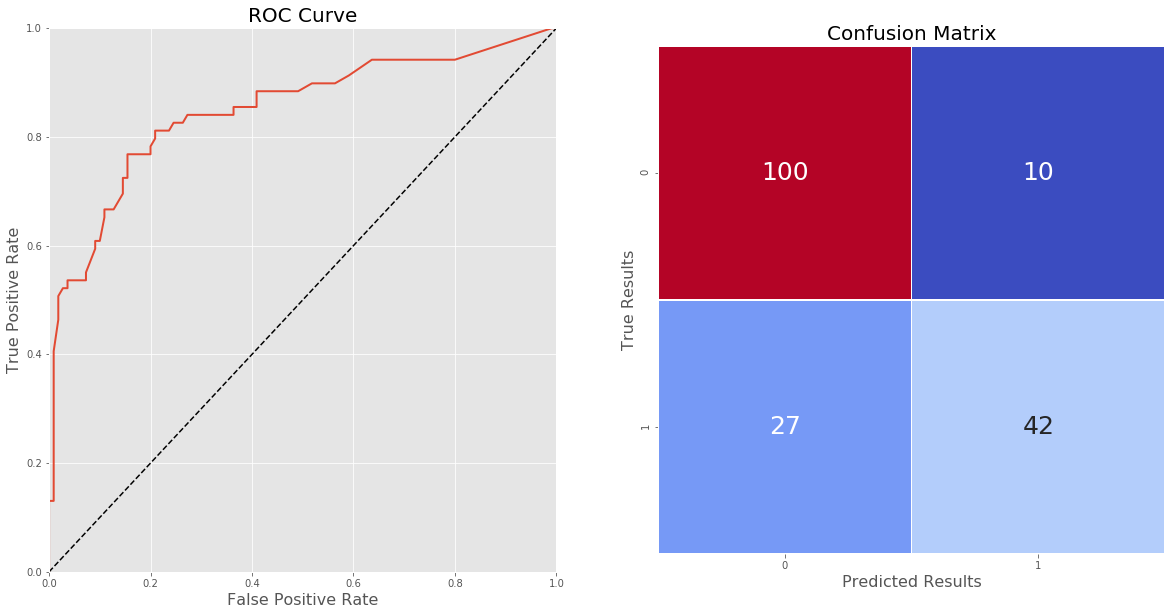

In [74]:
#Inspect Results:

Display_Model_Results(model_name, best_model, y_validate, X_validate)

### Step 5.3: Random Forest
***

In [76]:
#Initiate Model and Inspect Base Parameters:

RandomForest_clf = RandomForestClassifier()

RandomForest_clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [77]:
#Create Grid Search Parameters based on Parameters:

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['log2', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False],
               'criterion':['gini','entropy']}


In [78]:
#Set GridSearch Using RandomizedSearchCV:

kfold = KFold(n_splits=10, random_state=42)

model_random = RandomizedSearchCV(estimator=RandomForest_clf,
                                  param_distributions=random_grid,
                                  n_iter=100,
                                  cv=kfold,
                                  verbose=1,
                                  random_state=42,
                                  scoring="accuracy",
                                  n_jobs=4)

In [79]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

model_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   20.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.7min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  6.1min finished


Executed in: 0 days 00:06:04.566166


In [80]:
#Choose the Best Model Calculated:

model_name = 'RandomForest'

best_model = model_random.best_estimator_

RandomForest Model: 86.24%


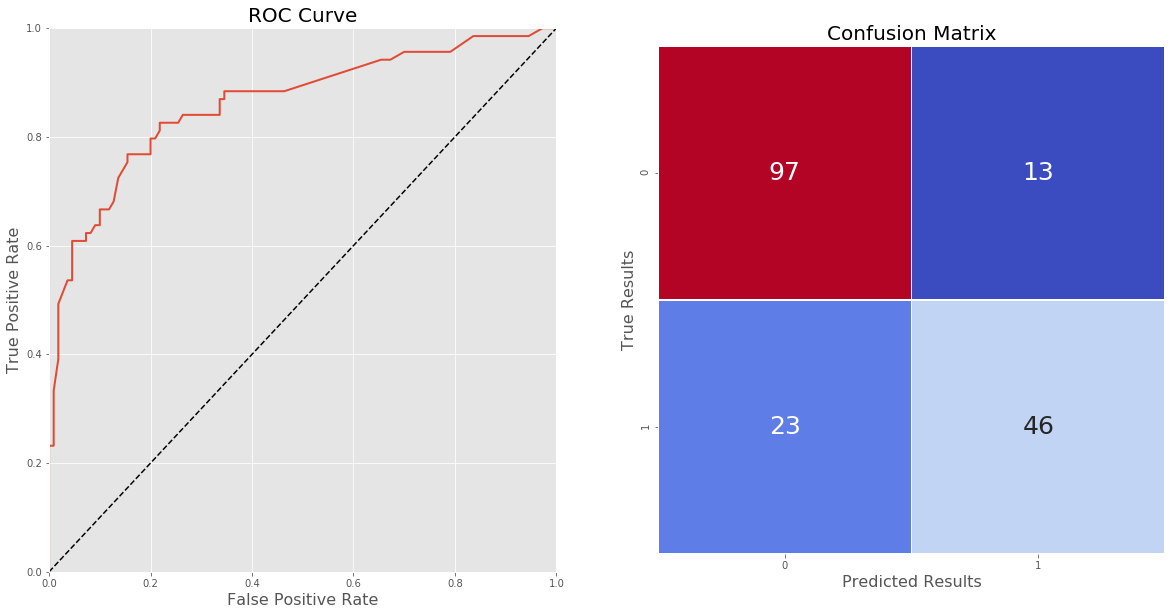

In [81]:
#Inspect Results:

Display_Model_Results(model_name, best_model, y_validate, X_validate)

### Step 5.4: GradientBoosting Classifier¶
***

In [83]:
#Initiate Model and Inspect Base Parameters:

GradientBoosting_clf = GradientBoostingClassifier()

GradientBoosting_clf.get_params()

{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [85]:
#Create Grid Search Parameters based on Parameters:

random_grid = {'n_estimators':[500, 1000, 1500, 2000, 2500], 
              'learning_rate':[0.01, 0.03, 0.05, 0.07, 0.09],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf':[3,5,7,9,11]}


In [86]:
#Set GridSearch Using RandomizedSearchCV:

kfold = KFold(n_splits=10, random_state=42)

model_random = RandomizedSearchCV(estimator=GradientBoosting_clf,
                                  param_distributions=random_grid,
                                  n_iter=100,
                                  cv=kfold,
                                  verbose=1,
                                  random_state=42,
                                  scoring="accuracy",
                                  n_jobs=4)

In [87]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

model_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   45.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  5.9min finished
C:\Users\silvada010\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Executed in: 0 days 00:05:55.198842


In [88]:
#Choose the Best Model Calculated:

model_name = 'GradientBoosting'

best_model = model_random.best_estimator_

GradientBoosting Model: 82.44%


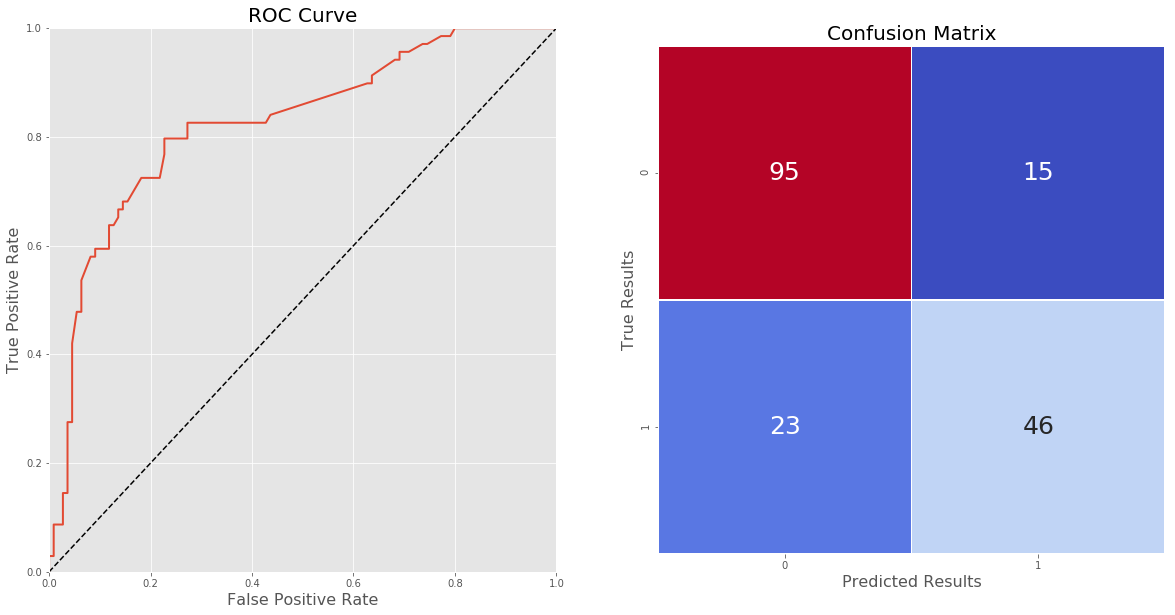

In [89]:
#Inspect Results:

Display_Model_Results(model_name, best_model, y_validate, X_validate)

### Step 5.5: xgboost
***

In [90]:
#Initiate Model and Inspect Base Parameters:

xgb_clf = XGBClassifier(objective='binary:logistic',silent=True, nthread=1)

xgb_clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': 1,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1,
 'verbosity': 1}

In [91]:
#Create Grid Search Parameters based on Parameters:

random_grid = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05],
               'n_estimators' : [100, 300, 600, 900, 1000],
               'min_child_weight': [1, 5, 10],
               'gamma': [0.5, 1, 1.5, 2, 5] ,
               'subsample': [0.8, 0.9, 1.0] ,
               'colsample_bytree': [0.3, 0.5, 0.7, 0.8],
               'max_depth': [3, 4, 5]
               }


In [92]:
#Set GridSearch Using RandomizedSearchCV:

kfold = KFold(n_splits=10, random_state=42)

model_random = RandomizedSearchCV(estimator=xgb_clf,
                                  param_distributions=random_grid,
                                  n_iter=100,
                                  cv=kfold,
                                  verbose=1,
                                  random_state=42,
                                  scoring="accuracy",
                                  n_jobs=4)

In [93]:
#Fit Model with RandomizedSearchGrid:

start_time = pd.Timestamp.today()

model_random.fit(X_train,y_train)

end_time = pd.Timestamp.today()

print("Executed in: {}".format(end_time - start_time))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   26.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  2.7min finished


Executed in: 0 days 00:02:42.739722


In [94]:
#Choose the Best Model Calculated:

model_name = 'xgboost'

best_model = model_random.best_estimator_

xgboost Model: 85.65%


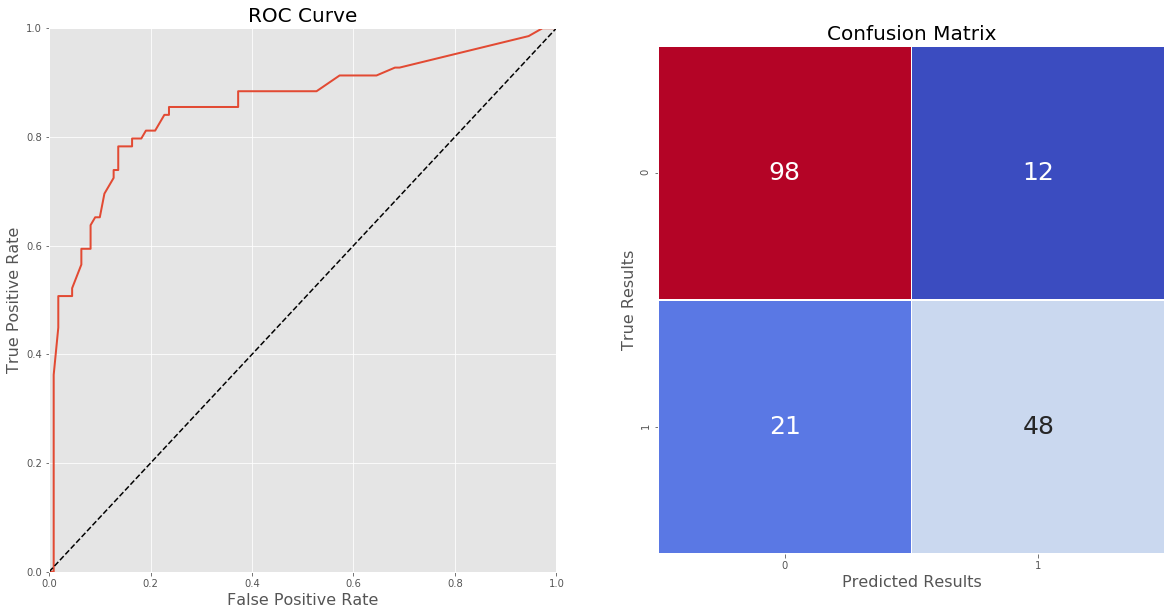

In [95]:
#Inspect Results:

Display_Model_Results(model_name, best_model, y_validate, X_validate)

## Step 6: Compare Results and Choose Model
***

### Step 6.1:  Model Results
***

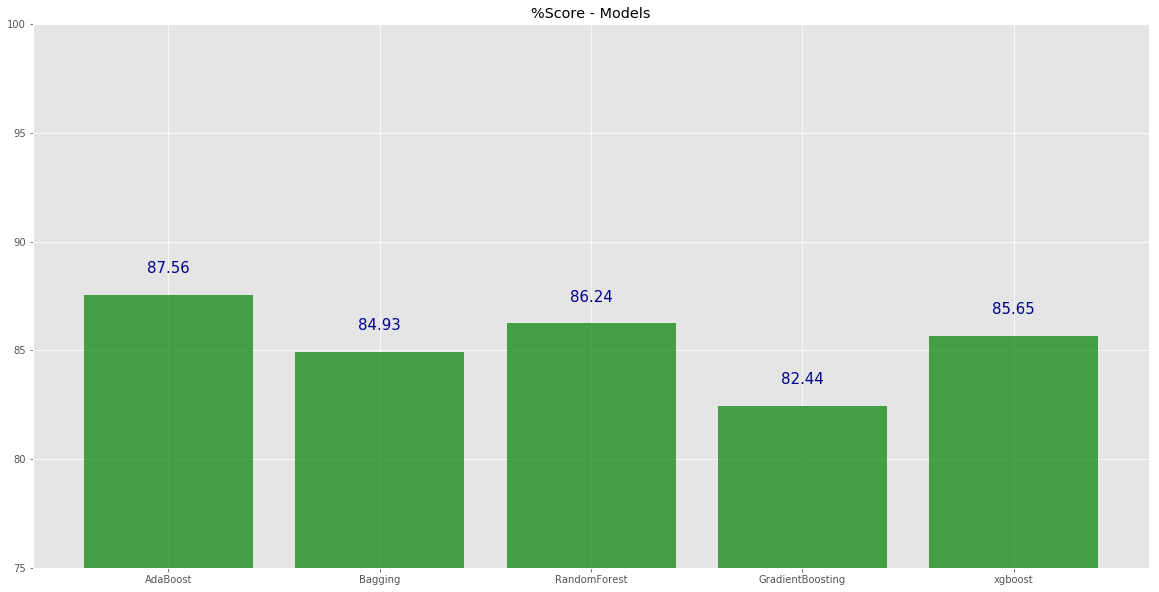

In [127]:
#Plot Main Results from Models:

results = [value[0] for (key, value) in model_matrix.items()]
names = [key for (key, value) in model_matrix.items()]
x_bar = list(range(0,len(names)))

_= plt.figure(figsize=(20,10))

_= plt.bar([key for (key, value) in model_matrix.items()],[value[0] for (key, value) in model_matrix.items()], color='green', alpha=0.7)

for i in range(len(x_bar)):
    _= plt.annotate(results[i],(x_bar[i] , results[i]+1), size=15, color='darkblue', horizontalalignment='center')

_= plt.ylim((75,100))

_= plt.title('%Score - Models')

In [129]:
#Save Best Model:

joblib.dump(model_matrix['AdaBoost'][1], 'pred_model_best.model')

['pred_model_best.model']